In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]

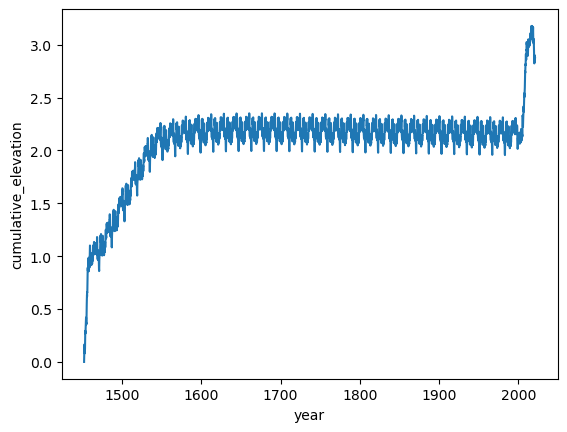

In [2]:
### Melt, Rain & Sublimation Off
ds['cumulative_elevation'].plot.line(x='year')

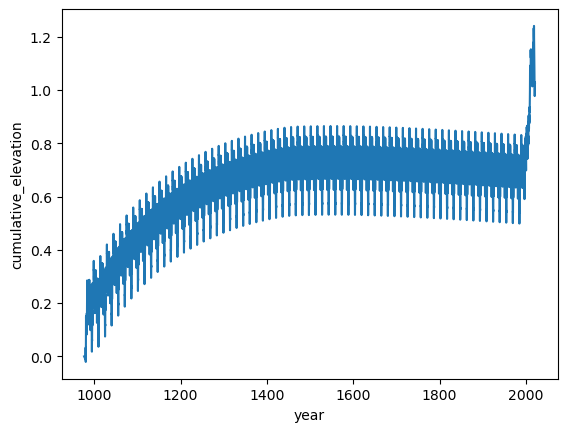

In [3]:
### Rain & Melt On, Sublim Off
ds['cumulative_elevation'].plot.line(x='year')

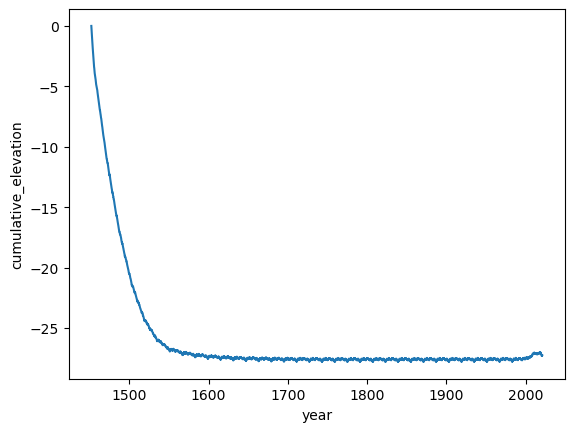

In [3]:
### Rain & Melt On, Sublim Off + More Melt
ds['cumulative_elevation'].plot.line(x='year')

In [5]:
ds = ds.swap_dims({"time": "year"})

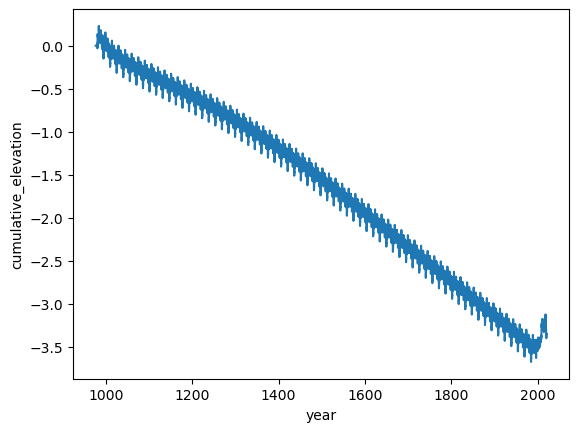

In [2]:
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')

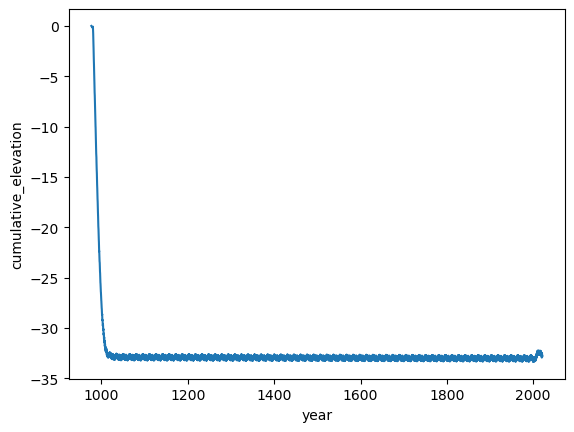

In [2]:
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')

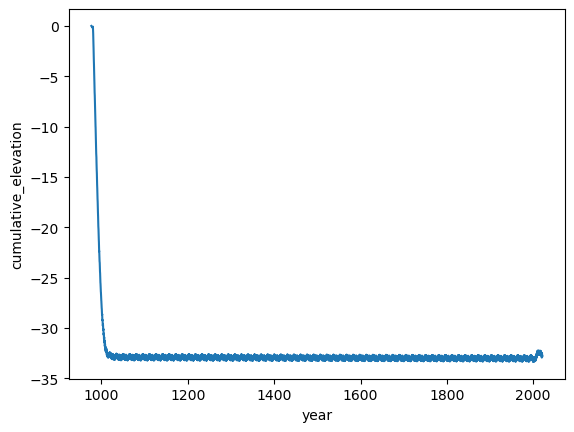

In [2]:
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')

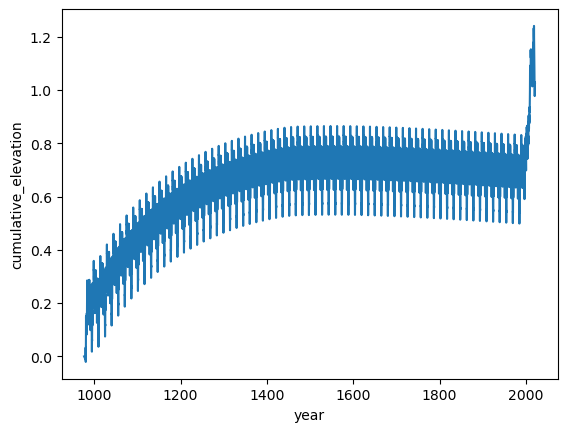

In [2]:
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')

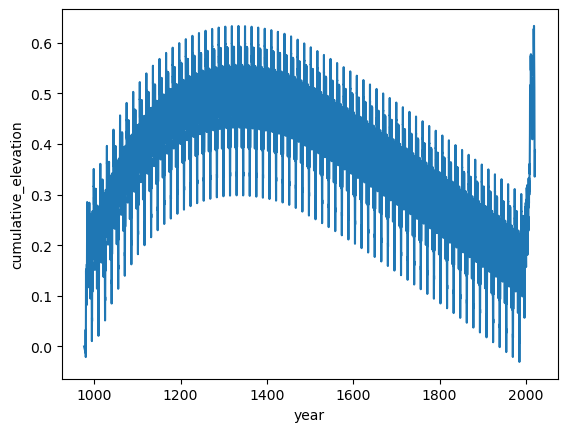

In [2]:
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')

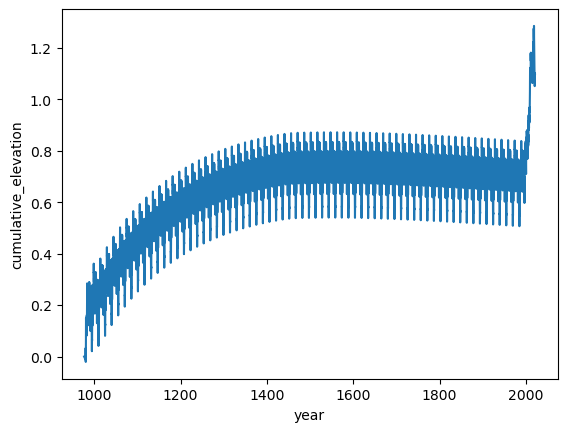

In [2]:
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')

In [6]:
ds_selection = ds.sel(year=np.arange(976,2100,100),method='nearest')[['depth','density']]

In [24]:
ds_selection

<xarray.Dataset>
Dimensions:  (year: 11, cell: 6566)
Coordinates:
  * year     (year) float32 1e+03 1.1e+03 1.2e+03 ... 1.8e+03 1.9e+03 2e+03
Dimensions without coordinates: cell
Data variables:
    depth    (year, cell) float32 ...
    density  (year, cell) float32 ...

In [34]:
ds_initial = ds.isel(year=0)[['depth','density']]
ds_end = ds.isel(year=-1)[['depth','density']]

In [37]:
ds_initial.year.data

array(976.4905, dtype=float32)

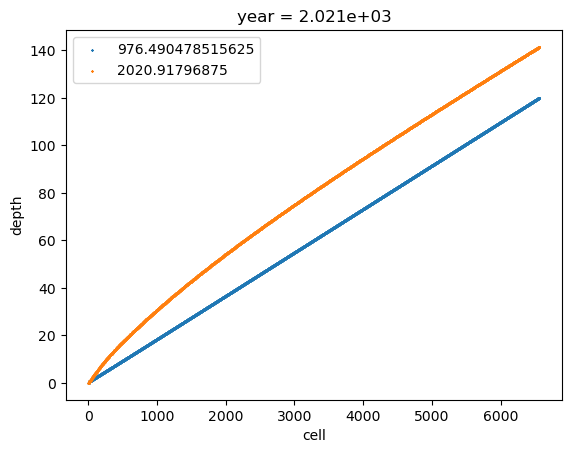

In [43]:
ds_initial.plot.scatter(x='cell', y='depth',marker='x',s=1,label=f'{ds_initial.year.data}')
ds_end.plot.scatter(x='cell', y='depth',marker='x',s=1,label=f'{ds_end.year.data}')
plt.legend()

/home/jez/anaconda3/envs/CFM/lib/python3.11/site-packages/xarray/plot/plot.py:952: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[v.to_numpy().ravel() for v in plts], **kwargs)


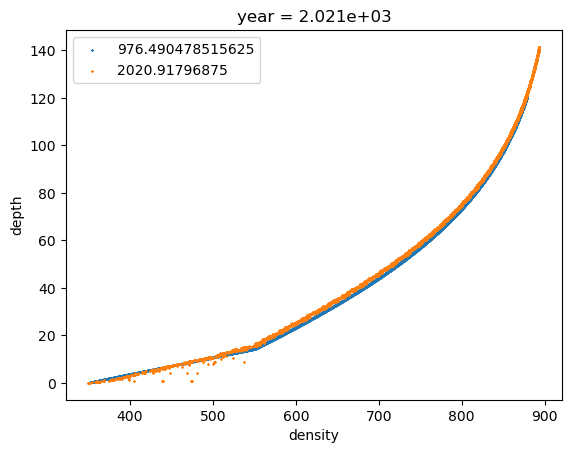

In [39]:
ds_initial.plot.scatter(x='density', y='depth',marker='x',s=1,label=f'{ds_initial.year.data}')
ds_end.plot.scatter(x='density', y='depth',marker='x',s=1,label=f'{ds_end.year.data}')
plt.legend()

/home/jez/anaconda3/envs/CFM/lib/python3.11/site-packages/xarray/plot/plot.py:952: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  primitive = ax.scatter(*[v.to_numpy().ravel() for v in plts], **kwargs)


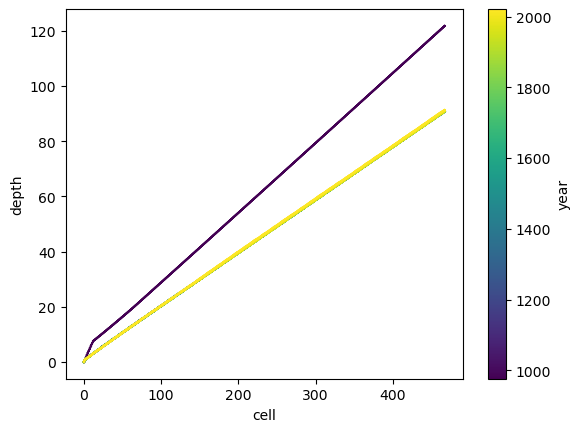

In [8]:
# ds_selection.plot.scatter(x='density', y='depth', hue='year',marker='x',s=1)
ds_selection.plot.scatter(x='cell', y='depth',hue='year',marker='x',s=1)#,label=f'{ds_initial.year.data}')
# ds_selection.plot.scatter(x='cell', y='density',hue='year',marker='x',s=1,label=f'{ds_initial.year.data}')
# ds_selection.plot.scatter(x='cell', y='depth',marker='x',s=1)#,label=f'{ds_initial.year.data}')


In [15]:
ds_selection.plot.scatter()

<xarray.Dataset>
Dimensions:               (year: 11, phony_dim_1: 8, cell: 6566,
                           phony_dim_3: 3, phony_dim_4: 13164, phony_dim_5: 5,
                           phony_dim_6: 2)
Coordinates:
  * year                  (year) float32 1e+03 1.1e+03 1.2e+03 ... 1.9e+03 2e+03
Dimensions without coordinates: phony_dim_1, cell, phony_dim_3, phony_dim_4,
                                phony_dim_5, phony_dim_6
Data variables: (12/16)
    DIP                   (year, phony_dim_1) float32 ...
    LWC                   (year, cell) float32 ...
    Modelclimate          (year, phony_dim_3) float32 1e+03 0.1841 ... 230.8
    age                   (year, cell) float32 ...
    density               (year, cell) float32 ...
    depth                 (year, cell) float32 ...
    ...                    ...
    isotopes_dD           (year, cell) float32 ...
    meltvol               (year, phony_dim_6) float32 1e+03 0.0 ... 2e+03 0.0
    refreeze              (year, phony_dim_6) float32 1e+03 0.0 ... 2e+03 0.0
    runoff                (year, phony_dim_6) float32 1e+03 0.0 ... 2e+03 0.0
    temperature           (year, cell) float32 ...
    cumulative_elevation  (year) float32 0.05628 -0.4195 ... -3.595 -4.053

In [12]:
depths = ds.depth.sel(year=np.arange(1000,2100,100),method='nearest')
densities = ds.density.sel(year=np.arange(1000,2100,100),method='nearest')

<xarray.DataArray 'density' (year: 11, cell: 6566)>
array([[350.     , 353.16205, 359.626  , ..., 878.4507 , 878.4679 , 878.48505],
       [350.     , 350.8412 , 353.494  , ..., 879.9817 , 879.9976 , 880.01355],
       [350.     , 350.64984, 355.2751 , ..., 882.07465, 882.0888 , 882.10297],
       ...,
       [350.     , 350.1312 , 350.35062, ..., 893.75995, 893.709  , 893.7599 ],
       [350.     , 350.36203, 350.7334 , ..., 893.84076, 893.79456, 893.71924],
       [350.     , 350.21136, 350.39108, ..., 893.75903, 893.78406, 893.8645 ]],
      dtype=float32)
Coordinates:
  * year     (year) float32 1e+03 1.1e+03 1.2e+03 ... 1.8e+03 1.9e+03 2e+03
Dimensions without coordinates: cell

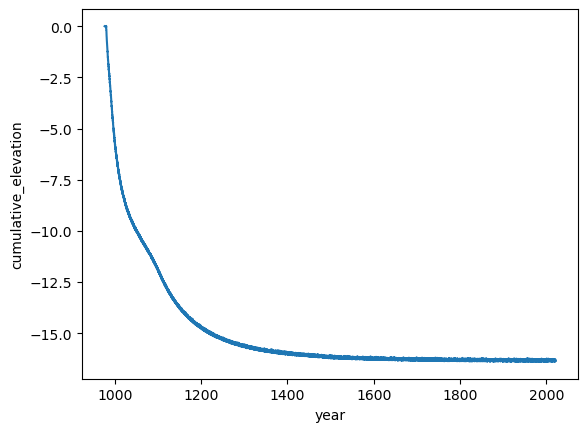

In [6]:
import xarray as xr
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')
# plt.vlines(1452, -15,0)

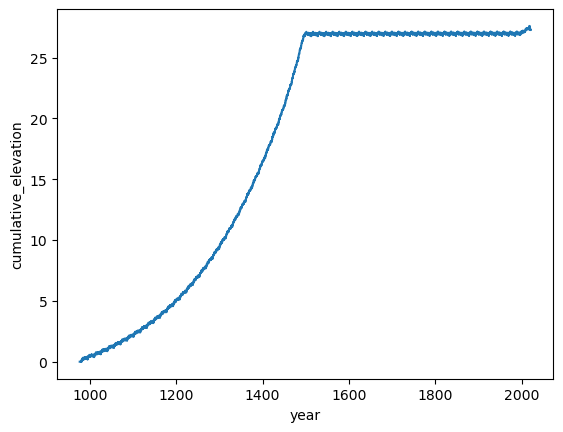

In [1]:
import xarray as xr
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,3]
ds['cumulative_elevation'].plot.line(x='year')

In [3]:
ds['cumulative_elevation'][1:]

<xarray.DataArray 'cumulative_elevation' (time: 768)>
array([-0.006495, -0.023058, -0.036416, ...,  0.288797,  0.295242,  0.287442],
      dtype=float32)
Coordinates:
    year     (time) float32 1.96e+03 1.96e+03 1.96e+03 ... 2.021e+03 2.021e+03
Dimensions without coordinates: time

In [7]:
ds.time

<xarray.DataArray 'time' (time: 13120)>
array([    0,     1,     2, ..., 13117, 13118, 13119])
Coordinates:
    year     (time) float32 976.5 980.1 980.1 ... 2.021e+03 2.021e+03 2.021e+03
Dimensions without coordinates: time

In [8]:
ds.swap_dims({"time": "year"})

<xarray.Dataset>
Dimensions:               (year: 13120, phony_dim_1: 8, cell: 481,
                           phony_dim_3: 3, phony_dim_4: 13164, phony_dim_5: 5,
                           phony_dim_6: 2)
Coordinates:
  * year                  (year) float32 976.5 980.1 ... 2.021e+03 2.021e+03
Dimensions without coordinates: phony_dim_1, cell, phony_dim_3, phony_dim_4,
                                phony_dim_5, phony_dim_6
Data variables: (12/16)
    DIP                   (year, phony_dim_1) float32 ...
    LWC                   (year, cell) float32 ...
    Modelclimate          (year, phony_dim_3) float32 ...
    age                   (year, cell) float32 ...
    density               (year, cell) float32 ...
    depth                 (cell) float64 ...
    ...                    ...
    isotopes_dD           (year, cell) float32 ...
    meltvol               (year, phony_dim_6) float32 ...
    refreeze              (year, phony_dim_6) float32 ...
    runoff                (year, phony_dim_6) float32 ...
    temperature           (year, cell) float32 ...
    cumulative_elevation  (year) float32 ...

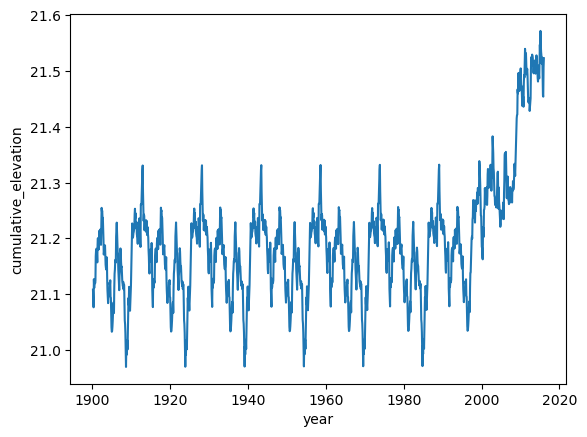

In [10]:
import xarray as xr
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,3]
# ds['cumulative_elevation'].plot.line(x='year')
ds = ds.swap_dims({"time": "year"})
ds = ds.sel(year=slice(1900,2016))
ds['cumulative_elevation'][1:].plot.line(x='year')


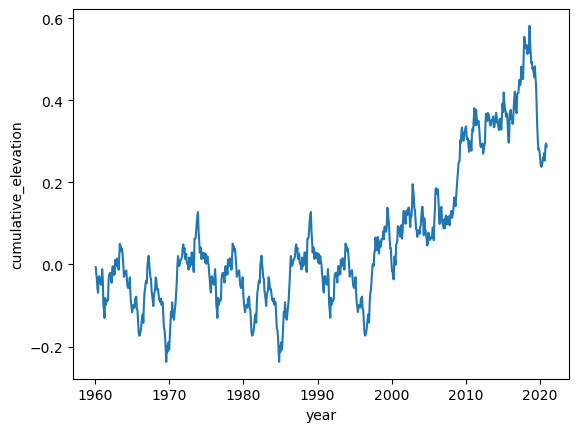

In [4]:
import xarray as xr
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,3]
# ds['cumulative_elevation'].plot.line(x='year')
ds['cumulative_elevation'][1:].plot.line(x='year')

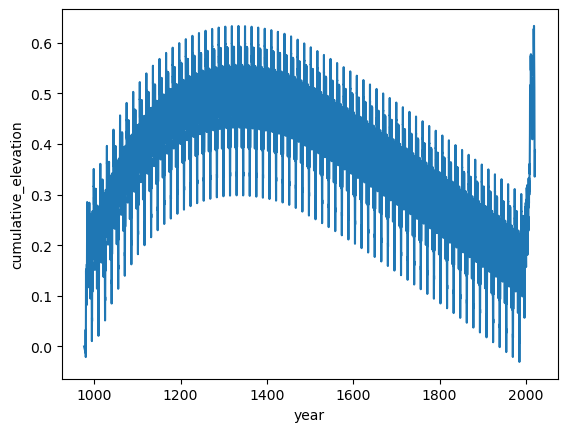

In [1]:
import xarray as xr
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')

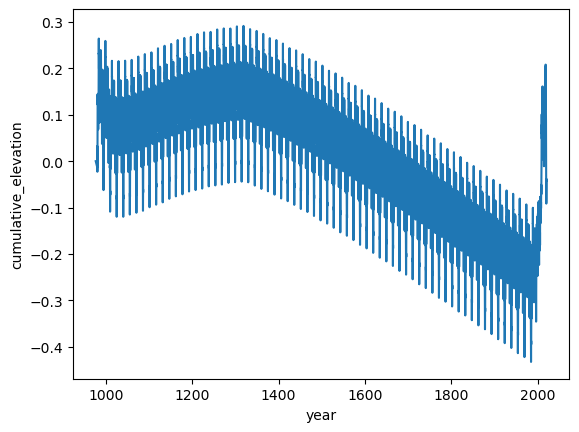

In [1]:
import xarray as xr
results_filename = '/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/results/CFMresults.hdf5'
ds = xr.open_dataset(results_filename)
dimensions_dict = {ds.density.dims[0]:'time',ds.density.dims[1]:'cell'}
ds = ds.rename_dims(dimensions_dict)
year_data = ds.isel(cell=0).density.data
ds = ds.assign_coords(year = ('time',year_data))
ds = ds.isel(cell=slice(1,None))
ds['cumulative_elevation']=ds.DIP[:,6]
ds['cumulative_elevation'].plot.line(x='year')

In [3]:
pwd

'/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/scripts'

In [2]:
import pandas as pd
import json
import subprocess

### Adjusting CSV for melt
# df = pd.read_csv('/home/jez/Community_Firn_Model_Forked/CFM_main/CFMinput_example/example_SMELT.csv')
df = pd.read_csv('/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/CFMinput_example/example_SMELT.csv')

In [ ]:
df[df.index > dateutil.parser.parse("2014-01-04")]

In [28]:
(df.T.index.astype('float32') > 1960)&(df.T.index.astype('float32') < 1980)

array([False, False, False, ..., False, False, False])

<AxesSubplot: >

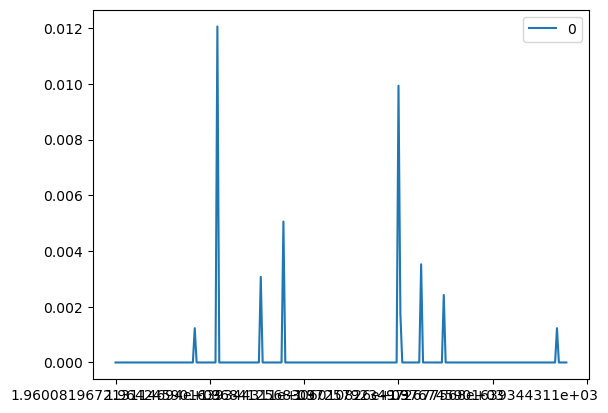

In [29]:
condition = (df.T.index.astype('float32') > 1960)&(df.T.index.astype('float32') < 1980)
df.T[condition].plot()

<AxesSubplot: >

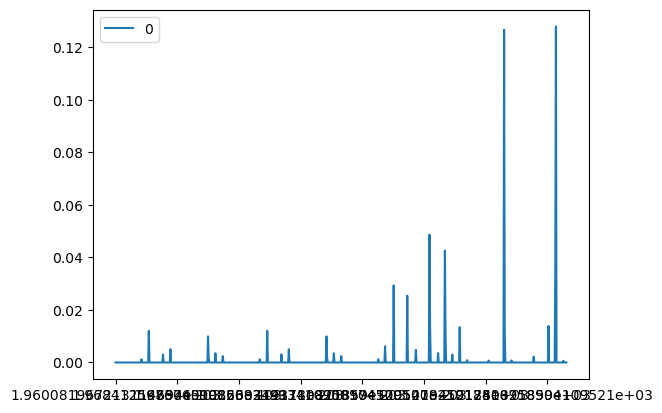

In [24]:
df.T[df.T.index.astype('float32') > 1960].plot()

<AxesSubplot: >

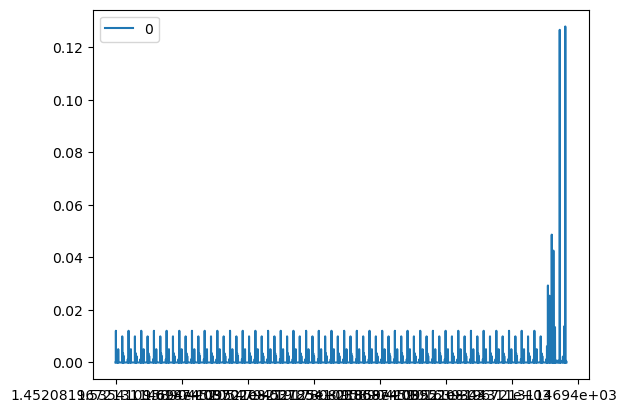

In [13]:
df.T.plot()

<AxesSubplot: >

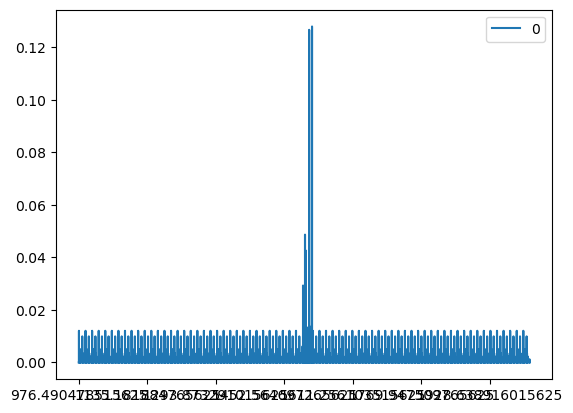

In [3]:
df.T.plot()

In [2]:
import glob

In [43]:
for f in glob.glob('/home/jez/Community_Firn_Model_Forked/CFM_main/CFMinput_example/example*'):
    df = pd.read_csv(f).T
    df_spin = df[df.index.astype('float32') < 1980]
    df_extended = pd.concat([df_spin,df])
    new_filename = f.split('/')[-1].replace('example','adjusted')
    df_extended.T.to_csv(f'/home/jez/Community_Firn_Model_Forked/SpinUp_Sensitivity_Example/CFMinput_example/{new_filename}',index=False, header=True)

In [44]:
old_index = df_extended.index.astype('float32')
step_size = old_index[1]-old_index[0]
new_index = np.arange(0,len(old_index))*step_size + old_index.max() - len(old_index)*step_size
df_extended.set_index(new_index)

In [60]:
df_extended.set_index(new_index)

,0
976.490479,234.635101
976.569824,230.551880
976.649170,233.876495
976.728516,237.308105
976.807861,253.448883
...,...
2020.600586,254.429367
2020.679932,241.634216
2020.759277,243.334595
2020.838623,230.772583


In [59]:
df_extended

,0
1.452081967213114694e+03,234.635101
1.452161202185792263e+03,230.551880
1.452245901639344311e+03,233.876495
1.452327868852459005e+03,237.308105
1.452412568306010826e+03,253.448883
...,...
2.020663934426229616e+03,254.429367
2.020745901639344311e+03,241.634216
2.020830601092896131e+03,243.334595
2.020912568306010826e+03,230.772583


In [54]:
import numpy as np
new_index = np.arange(0,len(old_index))*step_size + old_index.max() - len(old_index)*step_size


In [55]:
new_index

array([ 976.49047852,  976.56982422,  976.64916992, ..., 2020.75927734,
       2020.83862305, 2020.91796875])

In [53]:
old_index.max()

2020.997314453125

In [52]:
new_index.max()

1044.427490234375

In [ ]:
import numpy as np
start=0
step=1.25
num=9

result=np.arange(0,num)*step+start

In [45]:
old_index

Float64Index([1452.0819091796875, 1452.1612548828125,  1452.245849609375,
               1452.327880859375,   1452.41259765625, 1452.4945068359375,
              1452.5792236328125, 1452.6639404296875,  1452.745849609375,
                1452.83056640625,
              ...
               2020.245849609375,  2020.327880859375,   2020.41259765625,
              2020.4945068359375, 2020.5792236328125, 2020.6639404296875,
               2020.745849609375,   2020.83056640625,   2020.91259765625,
               2020.997314453125],
             dtype='float64', length=13164)

In [39]:
old_index.max()

2020.997314453125

In [37]:
step_size

0.079345703125

In [ ]:
def load_all_input_dataframes(path):
    df_all = None
    for f in glob.glob(path):
        df = pd.read_csv(f).T.reset_index()
        df.rename(columns = {"index":"time",0:f"{f.split('/')[-1]}"}, inplace = True)
        if df_all is None:
            df_all=df
        else:
            df_all = pd.merge(df_all,df,on='time')
    return(df_all)

In [ ]:
# df.T[0][:] = 1.0
# df.to_csv('/CommunityFirnModel/CFM_main/CFMinput_example/adjusted_SMELT.csv',index=False, header=True)

In [7]:
pd.concat([df.T,df.T])

,0
1.452081967213114694e+03,0.0
1.452161202185792263e+03,0.0
1.452245901639344311e+03,0.0
1.452327868852459005e+03,0.0
1.452412568306010826e+03,0.0
...,...
2.020663934426229616e+03,0.0
2.020745901639344311e+03,0.0
2.020830601092896131e+03,0.0
2.020912568306010826e+03,0.0


In [6]:
df.T

,0
1.452081967213114694e+03,0.0
1.452161202185792263e+03,0.0
1.452245901639344311e+03,0.0
1.452327868852459005e+03,0.0
1.452412568306010826e+03,0.0
...,...
2.020663934426229616e+03,0.0
2.020745901639344311e+03,0.0
2.020830601092896131e+03,0.0
2.020912568306010826e+03,0.0
